In [29]:
import os
import json

import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib notebook

In [4]:
# load the data

file_name = "polynome_ready_for_training.json"

with open(file_name, "r") as f:
    data = json.load(f)
    
print("keys: ", list(data.keys()))

keys:  ['states', 'actions', 'scores']


In [18]:
X = np.array(data["states"])
y = tf.keras.utils.to_categorical(np.array(data["actions"]), len(np.unique(data["actions"])))

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (4500, 160)
y shape:  (4500, 5)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.33, 
    random_state=42
)

In [33]:
# Creation of the model

def generate_nn(input_shape, output_shape, nunits=[10, 10], activation=["relu", "relu"]):

    assert len(nunits) == len(activation)

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for i, (nunits_, activation_) in enumerate(zip(nunits, activation)):
        model.add(
            tf.keras.layers.Dense(nunits_, activation=activation_, name=f"layer_{i+1}")
        )

    model.add(tf.keras.layers.Dense(output_shape, activation="softmax"))

    return model

nlayers = 3
config = dict(
    nunits=[100]*nlayers,
    activation=["relu"]*nlayers
)

model = generate_nn(X.shape[1:], y.shape[1], **config)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 100)               16100     
_________________________________________________________________
layer_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 36,805
Trainable params: 36,805
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)

history = model.fit(X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_data=(X_test, y_test),
    verbose=1
).history

Epoch 1/100
189/189 [==============================] - 1s 2ms/step - loss: 1.6455 - acc: 0.1704 - val_loss: 1.6369 - val_acc: 0.1360
Epoch 2/100
189/189 [==============================] - 0s 1ms/step - loss: 1.6088 - acc: 0.2061 - val_loss: 1.6568 - val_acc: 0.0734
Epoch 3/100
189/189 [==============================] - 0s 1ms/step - loss: 1.6005 - acc: 0.2170 - val_loss: 1.6799 - val_acc: 0.0606
Epoch 4/100
189/189 [==============================] - 0s 1ms/step - loss: 1.5928 - acc: 0.2317 - val_loss: 1.7126 - val_acc: 0.0599
Epoch 5/100
189/189 [==============================] - 0s 1ms/step - loss: 1.5836 - acc: 0.2284 - val_loss: 1.7414 - val_acc: 0.0498
Epoch 6/100
189/189 [==============================] - 0s 1ms/step - loss: 1.5736 - acc: 0.2430 - val_loss: 1.7800 - val_acc: 0.0350
Epoch 7/100
189/189 [==============================] - 0s 1ms/step - loss: 1.5626 - acc: 0.2438 - val_loss: 1.8459 - val_acc: 0.0242
Epoch 8/100
189/189 [==============================] - 0s 1ms/step - 

189/189 [==============================] - 0s 1ms/step - loss: 1.2749 - acc: 0.2743 - val_loss: 7.1979 - val_acc: 0.0020
Epoch 63/100
189/189 [==============================] - 0s 1ms/step - loss: 1.2693 - acc: 0.2761 - val_loss: 7.3984 - val_acc: 0.0020
Epoch 64/100
189/189 [==============================] - 0s 1ms/step - loss: 1.2769 - acc: 0.2805 - val_loss: 7.2728 - val_acc: 0.0027
Epoch 65/100
189/189 [==============================] - 0s 1ms/step - loss: 1.2764 - acc: 0.2889 - val_loss: 7.6442 - val_acc: 0.0027
Epoch 66/100
189/189 [==============================] - 0s 1ms/step - loss: 1.2820 - acc: 0.2748 - val_loss: 7.1452 - val_acc: 0.0027
Epoch 67/100
189/189 [==============================] - 0s 1ms/step - loss: 1.2809 - acc: 0.2914 - val_loss: 7.7268 - val_acc: 0.0027
Epoch 68/100
189/189 [==============================] - 0s 1ms/step - loss: 1.2750 - acc: 0.2817 - val_loss: 6.9965 - val_acc: 0.0027
Epoch 69/100
189/189 [==============================] - 0s 1ms/step - loss:

<IPython.core.display.Javascript object>


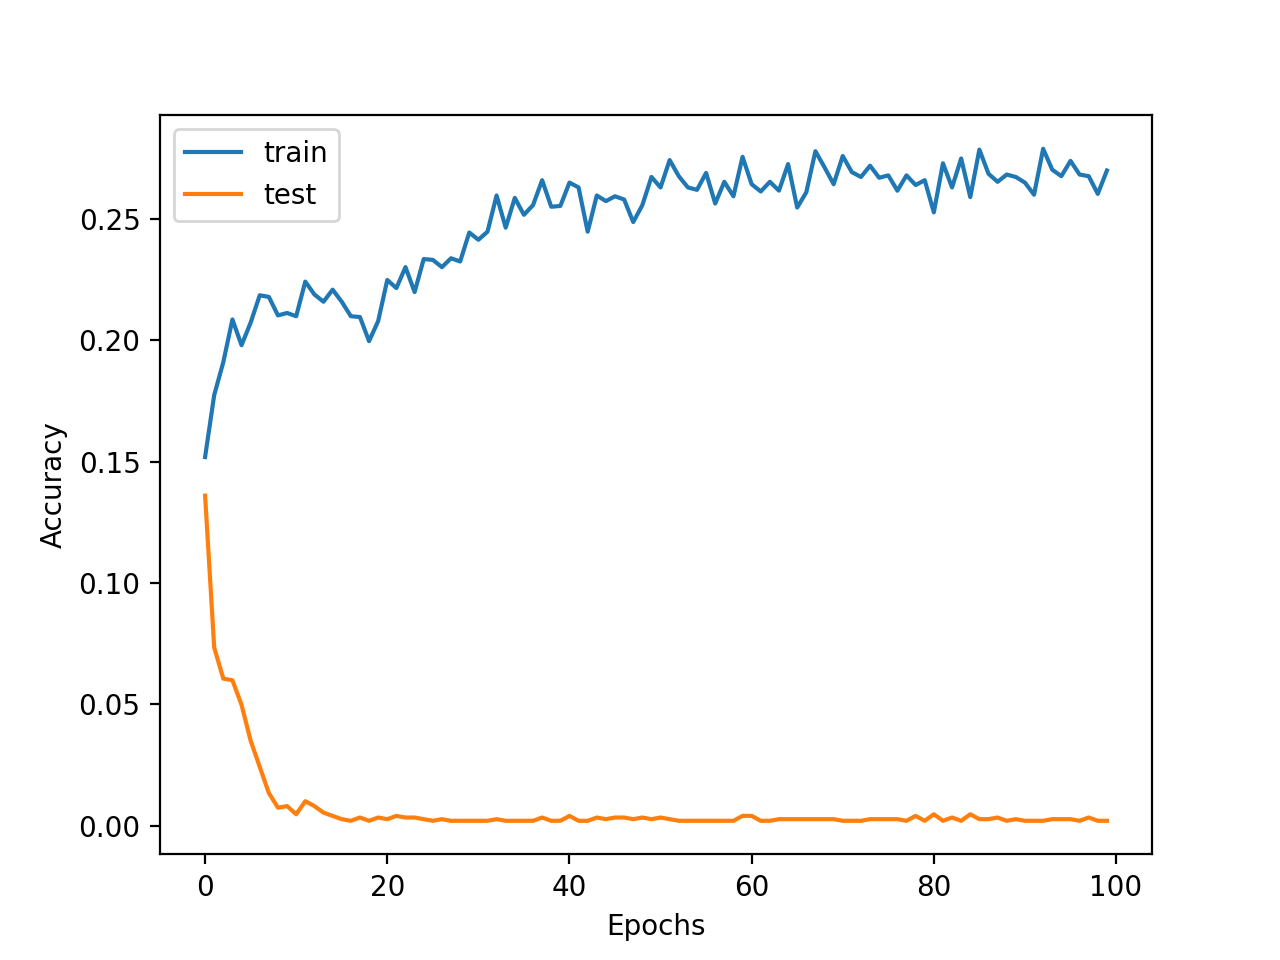

In [36]:
plt.figure()
plt.plot(history["acc"], label="train")
plt.plot(history["val_acc"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()